In [1]:
from PIL import Image
from model import AggMInterface
from data import DInterface
import yaml
import warnings
warnings.filterwarnings("ignore")

# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_14/hparams.yaml"
checkpoint_path = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_14/checkpoints/dinov2_backbone_epoch(39)_step(39080)_R1[0.9135]_R5[0.9595]_R10[0.9649].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path) as f:
    config = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module = DInterface(**config)  # 数据模块初始化，传入配置参数
transform = data_module.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()
model = model.model.model
model.requires_grad_(False)

/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/utils/hook_func.py:21: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [2]:
# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path1 = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_15/hparams.yaml"
checkpoint_path1 = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_15/checkpoints/dinov2_backbone_epoch(13)_step(13678)_R1[0.8919]_R5[0.9568]_R10[0.9649].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path1) as f:
    config1 = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module1 = DInterface(**config1)  # 数据模块初始化，传入配置参数
transform1 = data_module1.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model1 = AggMInterface.load_from_checkpoint(checkpoint_path1)
model1.eval()
model1 = model1.model.model
model1.requires_grad_(False)

正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [5]:
# 实例化dino v2，不微调
from torch.hub import load
import torch

model2 = load(
            # repo_or_dir="facebookresearch/dinov2",
            repo_or_dir='/home/cartolab3/.cache/torch/hub/facebookresearch_dinov2_main',
            model='dinov2_vitl14',
            trust_repo=True,
            source='local',
        )
model2.cuda()
model2.eval()
model2.requires_grad_(False)

def load_dino_v2(x):
    x = model2.prepare_tokens_with_masks(x)
    # 前向传播
    with torch.no_grad():
        for block in model2.blocks:
            x=block(x)
        # 获取最终输出
        x = model2.norm(x)
        x = x[:, 0]
        return x

In [29]:
import os
import glob

msls_path='sample_imgs/svox_rain'

labels=[]
feats_memory_bank=[]
feats_without_memory_bank=[]
feats_without_fineture=[]   

instances= os.listdir(msls_path)
for instance in instances:

    all_imgs=glob.glob(os.path.join(msls_path,instance,'*','*.jpg'))+glob.glob(os.path.join(msls_path,instance,'*','*.png'))
    labels.extend([int(instance)]*len(all_imgs))

    for img_path in all_imgs:
        # 可视化显著性图
        image= Image.open(img_path).convert("RGB")
        # 应用数据变换并将图像转移到GPU
        image= transform(image).unsqueeze(0).cuda()
        feats=model(image)
        feats1=model1(image)
        feats2=load_dino_v2(image)

        feats=feats.cpu().numpy()
        feats1=feats1.cpu().numpy()
        feats2=feats2.cpu().numpy()
        
        feats_memory_bank.extend(feats)
        feats_without_memory_bank.extend(feats1)
        feats_without_fineture.extend(feats2)

print(len(labels),len(feats_memory_bank),len(feats_without_memory_bank))


564 564 564


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
正在进行t-SNE降维，这可能需要几分钟...


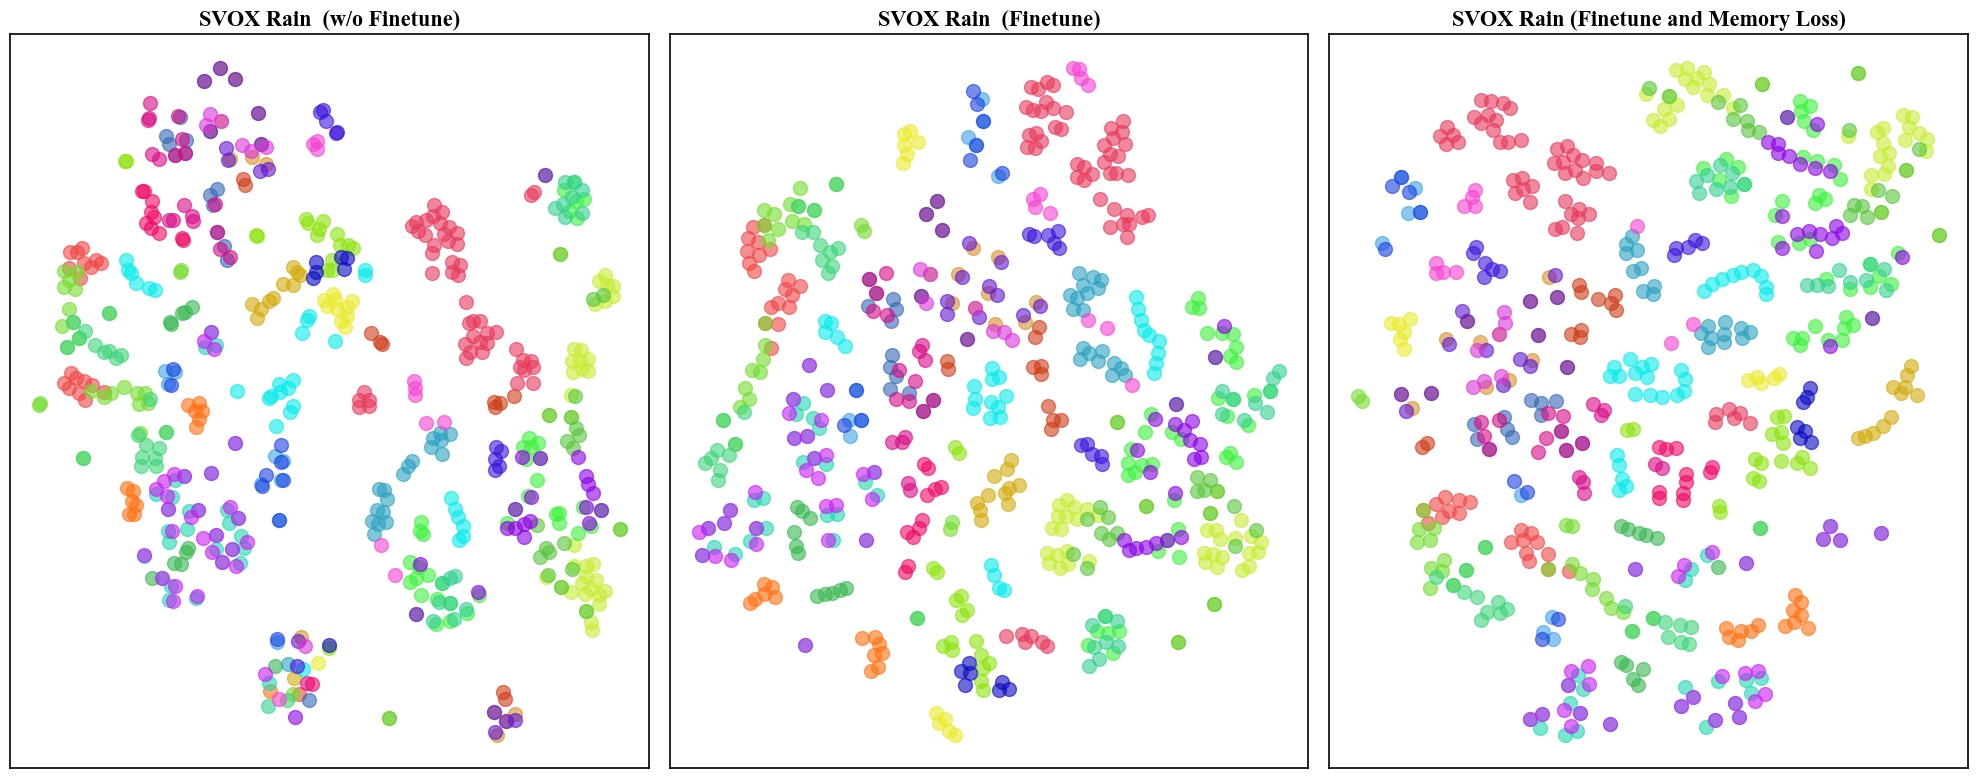

特征总数: 564
不同类别数: 30


In [30]:
# 可视化特征    

# 导入必要的库
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import colorsys

def generate_distinct_colors(n):
    """生成n个视觉上易于区分的颜色"""
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7 + np.random.rand() * 0.3  # 0.7-1.0之间的随机值
        value = 0.7 + np.random.rand() * 0.3       # 0.7-1.0之间的随机值
        colors.append(colorsys.hsv_to_rgb(hue, saturation, value))
    return colors

unique_labels = np.unique(labels)
print(unique_labels)
n_labels = len(unique_labels)
colors=generate_distinct_colors(n_labels)
color_map = dict(zip(unique_labels, colors))

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 1.2,
    'lines.linewidth': 2.5,
    'lines.markersize': 10,
    'grid.linewidth': 0.8,
})


# 将特征列表转换为numpy数组
feats_memory_bank = np.array(feats_memory_bank)
feats_without_memory_bank = np.array(feats_without_memory_bank)
feats_without_fineture=np.array(feats_without_fineture)
# 使用t-SNE进行降维
# n_components=2 表示降至2维用于可视化
# random_state设定随机种子，确保结果可复现
print("正在进行t-SNE降维，这可能需要几分钟...")

tsne_memory = TSNE(n_components=2, random_state=42)
tsne_without = TSNE(n_components=2, random_state=42)
tsne_without_fineture = TSNE(n_components=2, random_state=42)

# 对两组特征分别进行降维
embedded_memory = tsne_memory.fit_transform(feats_memory_bank)
embedded_without = tsne_without.fit_transform(feats_without_memory_bank)
embedded_without_fineture = tsne_without_fineture.fit_transform(feats_without_fineture)

# 创建一个包含两个子图的图表
plt.figure(figsize=(20, 8))

# 绘制带记忆库的特征分布
plt.subplot(133)
for label in unique_labels:
    mask = labels == label
    plt.scatter(embedded_memory[mask, 0], embedded_memory[mask, 1], 
               c=[color_map[label]], label=f'Class {label}',
               alpha=0.6)
plt.title('SVOX Rain (Finetune and Memory Loss)',fontweight='bold')
plt.xticks([])  # 隐藏x轴刻度
plt.yticks([])  # 隐藏y轴刻度

# 绘制不带记忆库的特征分布
plt.subplot(132)
for label in unique_labels:
    mask = labels == label
    plt.scatter(embedded_without[mask, 0], embedded_without[mask, 1], 
               c=[color_map[label]], label=f'Class {label}',
               alpha=0.6)
plt.title('SVOX Rain  (Finetune)',fontweight='bold')
plt.xticks([])  # 隐藏x轴刻度
plt.yticks([])  # 隐藏y轴刻度

# 绘制不带微调的特征分布
plt.subplot(131)
for label in unique_labels:
    mask = labels == label
    plt.scatter(embedded_without_fineture[mask, 0], embedded_without_fineture[mask, 1], 
               c=[color_map[label]], label=f'Class {label}',
               alpha=0.6)
plt.title('SVOX Rain  (w/o Finetune)',fontweight='bold')
plt.xticks([])  # 隐藏x轴刻度
plt.yticks([])  # 隐藏y轴刻度

# 调整子图之间的间距
plt.tight_layout()

# 保存图像
plt.savefig(os.path.join('some_result_images','SVOX_Rain _tsne_visualization.png'), dpi=600, bbox_inches='tight')
plt.show()

# 输出一些基本统计信息
print(f"特征总数: {len(labels)}")
print(f"不同类别数: {len(np.unique(labels))}")